In [ ]:
from sklearn.model_selection import train_test_split
from experiment import tune_architecture, tune_hyperparameters, plot_confusion_matrices, plot_roc_curves, plot_losses
from model import predict
from sklearn.metrics import accuracy_score
import pandas as pd
import torch
import preprocessing
import numpy as np

# Data preprocessing

In [2]:
df = pd.read_csv("train_data.csv")
df.head()

,SalePrice,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,141592,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0
1,51327,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
2,48672,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
3,380530,2006,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0
4,78318,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0


## Check for duplicated rows

In [3]:
df.duplicated().sum()
df = df.drop_duplicates()

## Assign labels

In [4]:
df["Label"] = df["SalePrice"].apply(preprocessing.classify)
df = df.drop(columns=["SalePrice"])
df.head()

,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total),Label
0,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0,1
1,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0,0
2,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0,0
3,2006,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0,2
4,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0,0


## Check for missing values

In [5]:
preprocessing.missing(df, df.columns)

{}

# Categorical data

In [6]:
numeric_columns = df._get_numeric_data().columns
categorical_columns = list(set(df.columns) - set(numeric_columns))
numeric_columns = list(set(numeric_columns) - {'Label'})

In [7]:
categorical_unique = preprocessing.unique(df, categorical_columns)
numeric_unique = preprocessing.unique(df, numeric_columns)

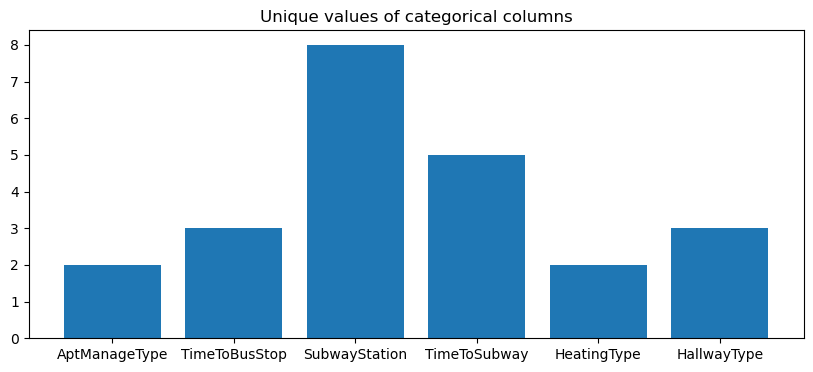

In [8]:
preprocessing.plot_bar(categorical_unique, "Unique values of categorical columns")

In [9]:
counts_by_label = dict(df["Label"].value_counts())
label_assignment = {0: "cheap (0)", 1:"average (1)", 2:"expensive (2)"}
counts_by_label = {label_assignment[key]: val for key, val in counts_by_label.items()}

In [10]:
ordinal_columns = ["TimeToBusStop", "TimeToSubway"]
nominal_columns = list(set(categorical_columns) - set(ordinal_columns))

## Check for outliers 

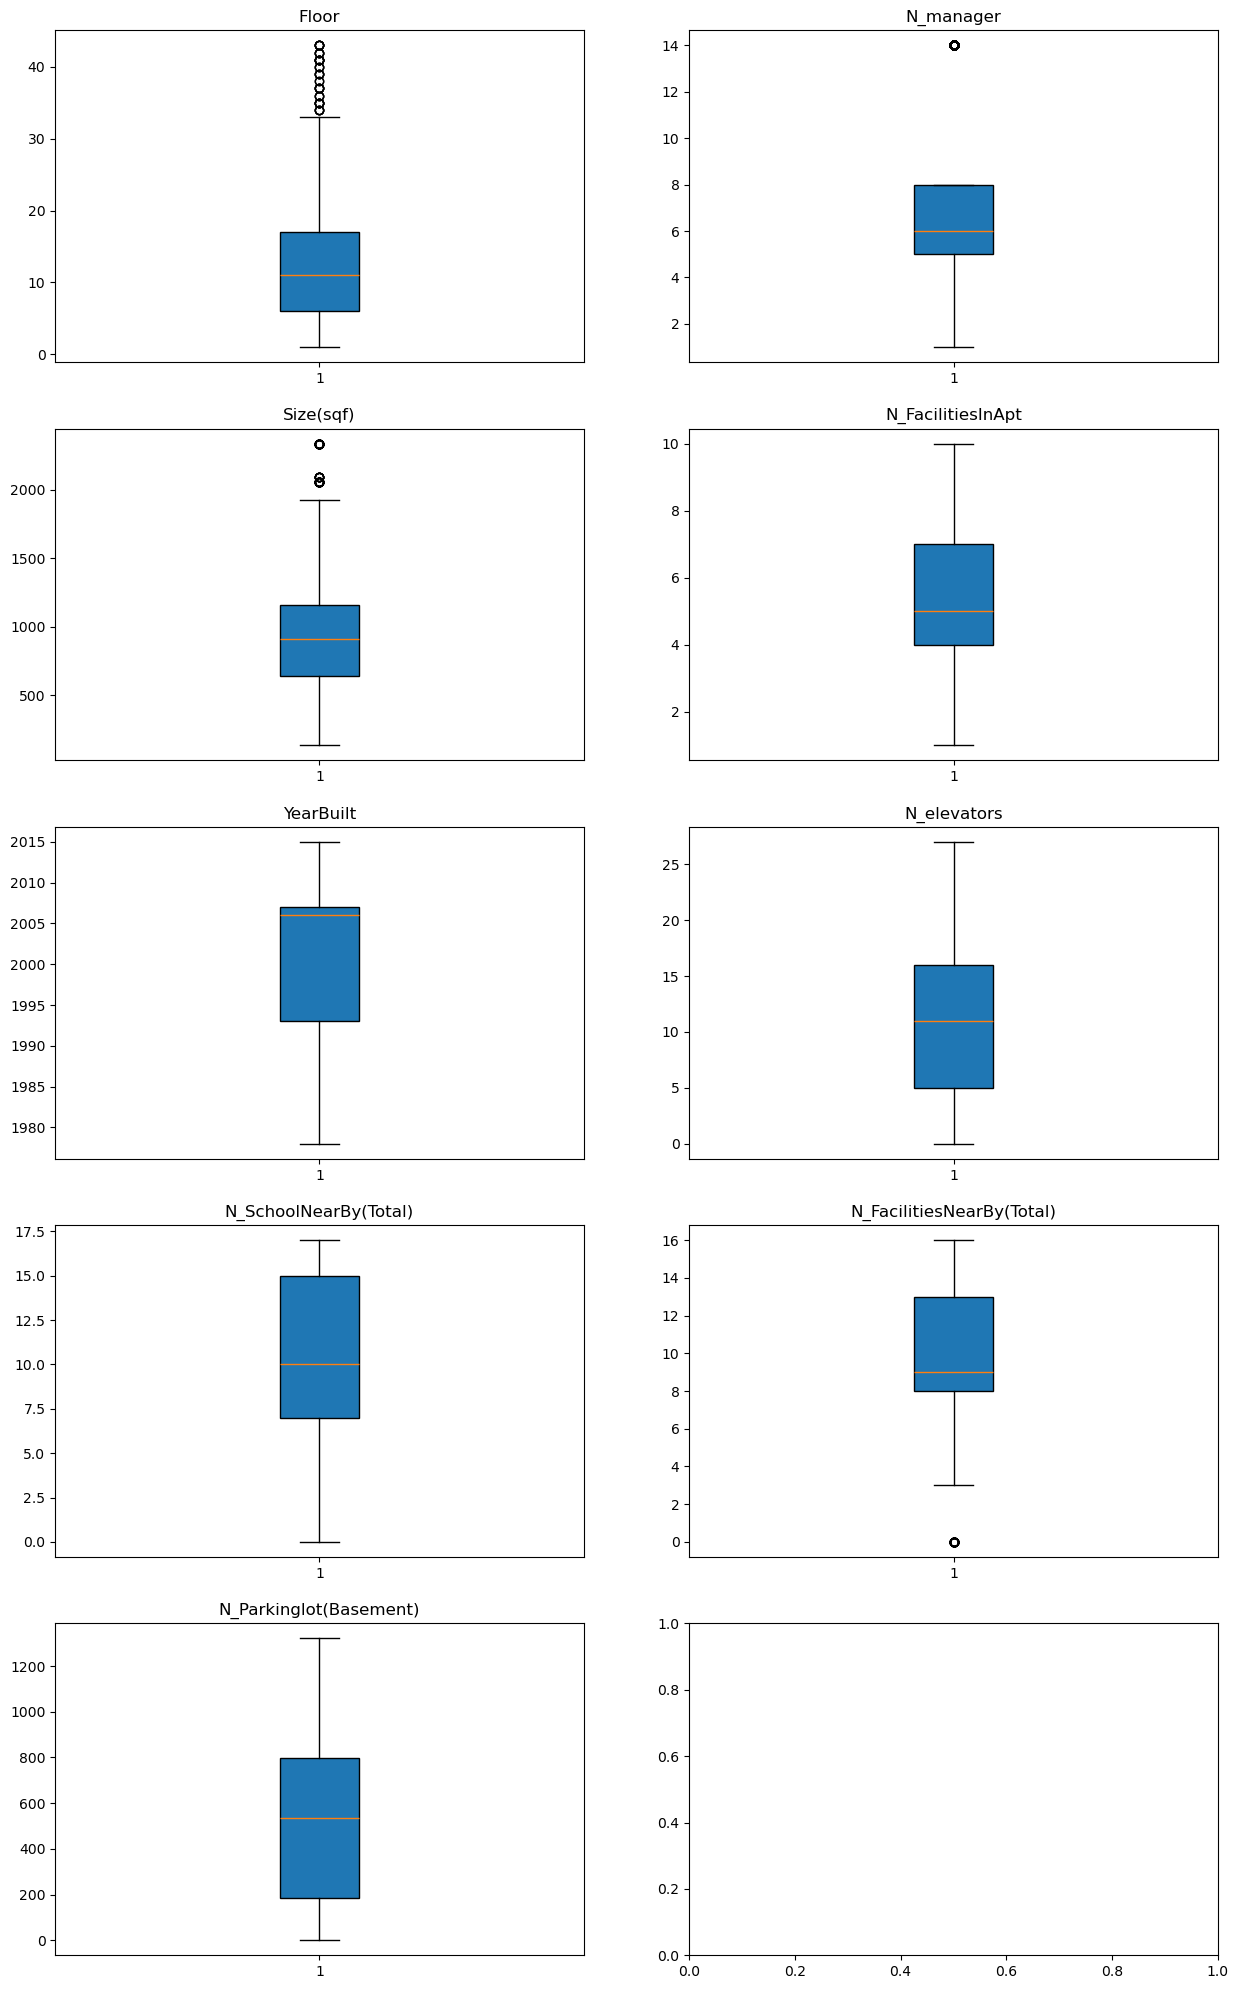

In [11]:
preprocessing.plot_boxplot(df, numeric_columns)

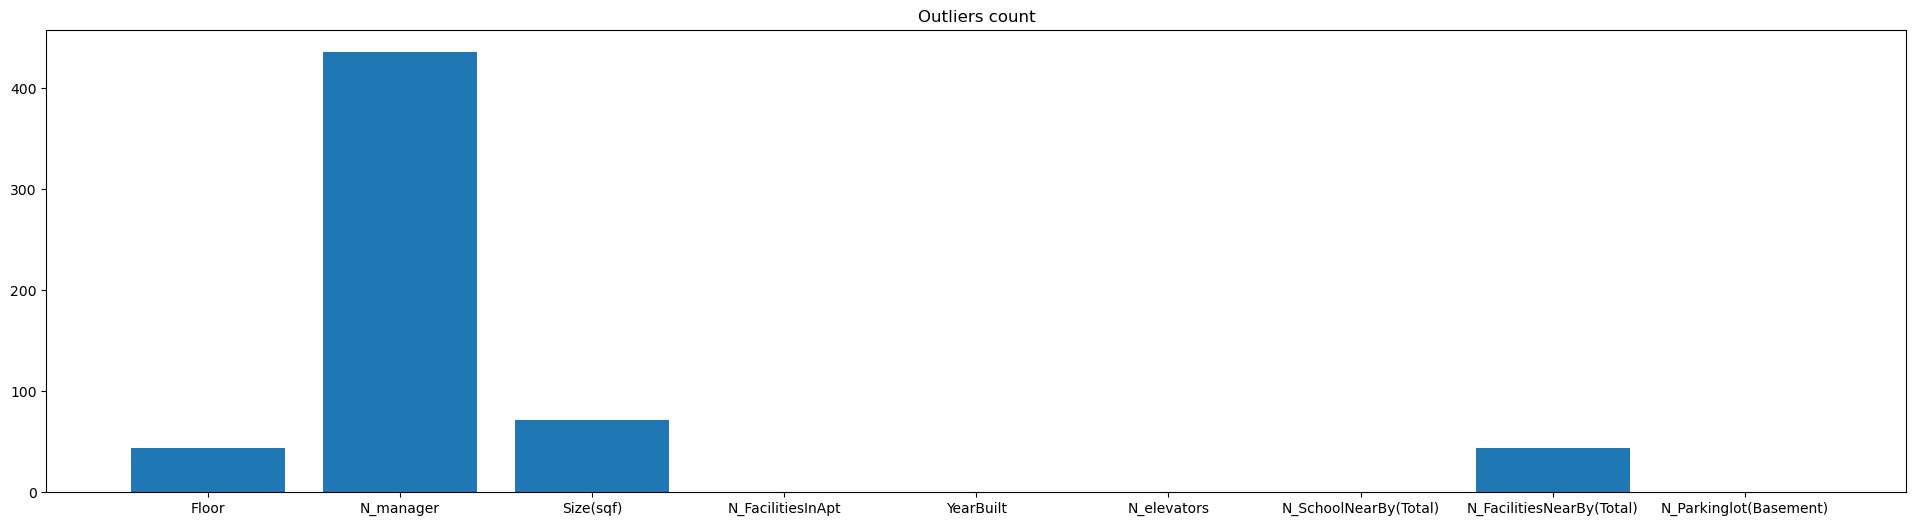

In [12]:
outliers_counts, outliers = preprocessing.check_outliers(df, numeric_columns)
preprocessing.plot_bar(outliers_counts, "Outliers count", size=(24, 6))

Since we don't have much data and the outliers are not too extreme we've decided to let them be.

## Analyze if some features have normal distribution
We analyze the distribution of the features to decide how to normalize the data.

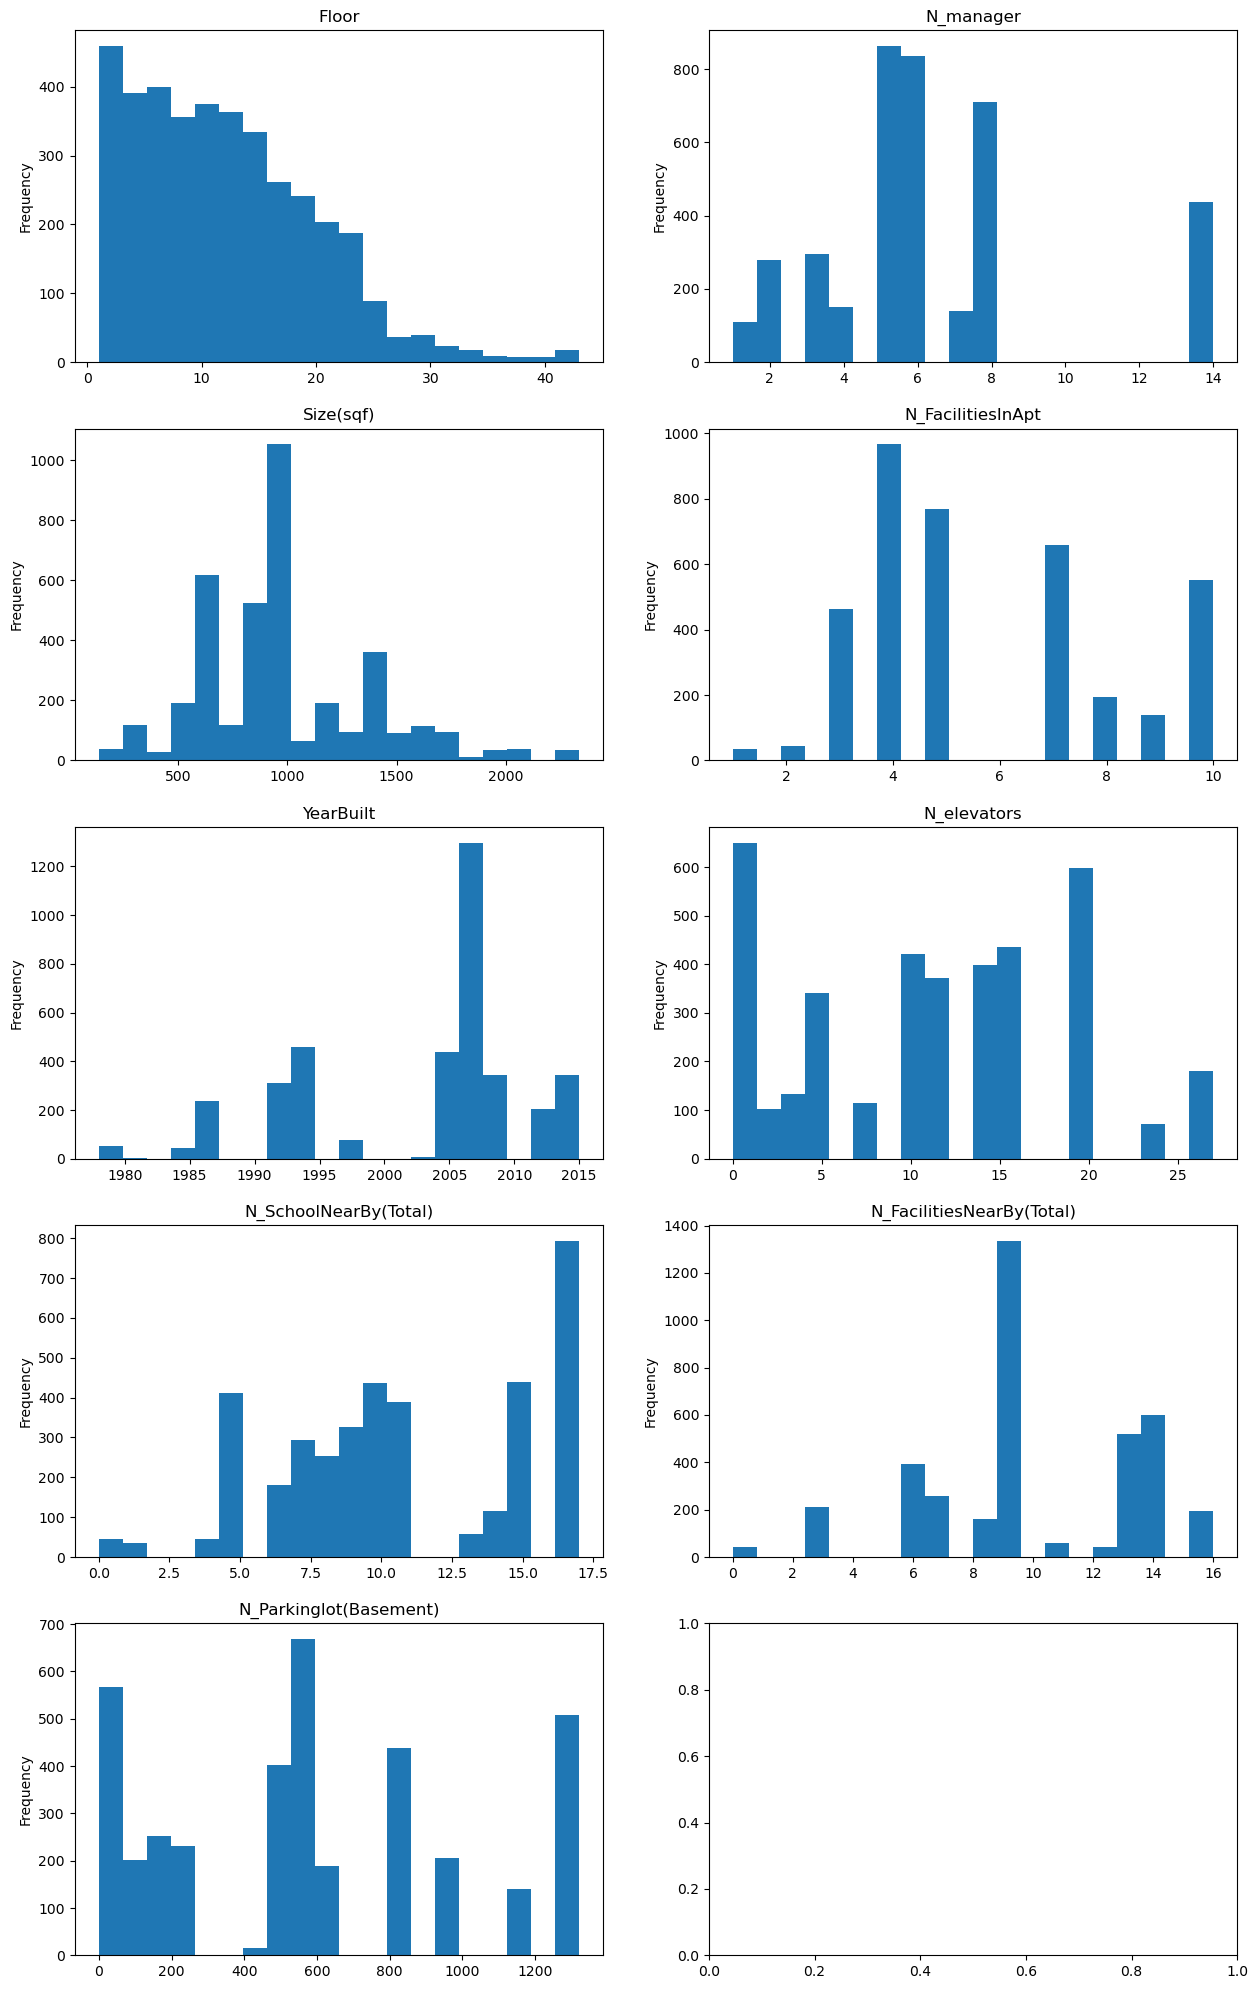

In [13]:
preprocessing.plot_histograms(df, numeric_columns)

In [14]:
preprocessing.shapiro_wilk(df, numeric_columns)

{'Floor': 'not normally distributed',
 'N_manager': 'not normally distributed',
 'Size(sqf)': 'not normally distributed',
 'N_FacilitiesInApt': 'not normally distributed',
 'YearBuilt': 'not normally distributed',
 'N_elevators': 'not normally distributed',
 'N_SchoolNearBy(Total)': 'not normally distributed',
 'N_FacilitiesNearBy(Total)': 'not normally distributed',
 'N_Parkinglot(Basement)': 'not normally distributed'}

## Categorical features distribution

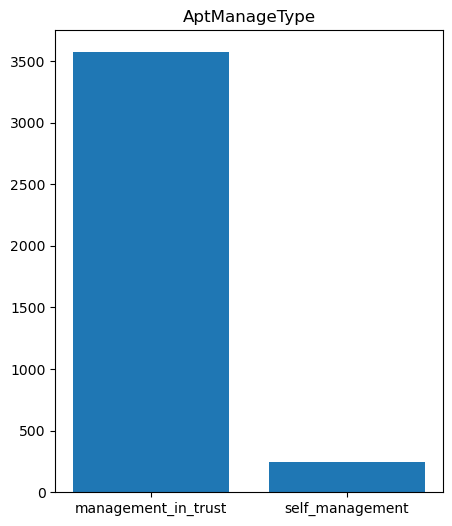

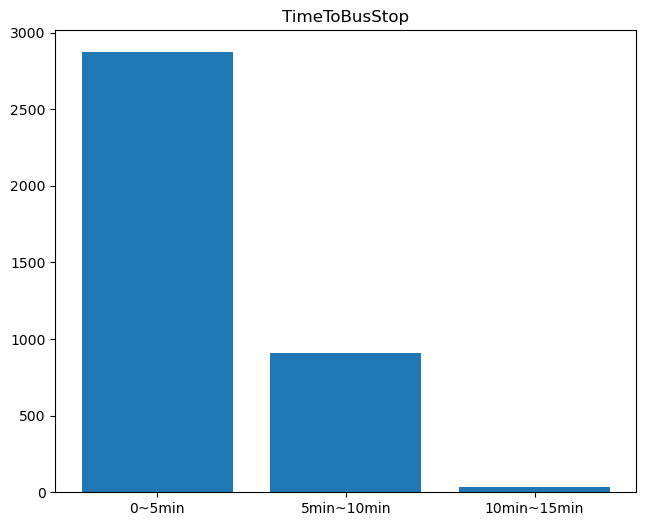

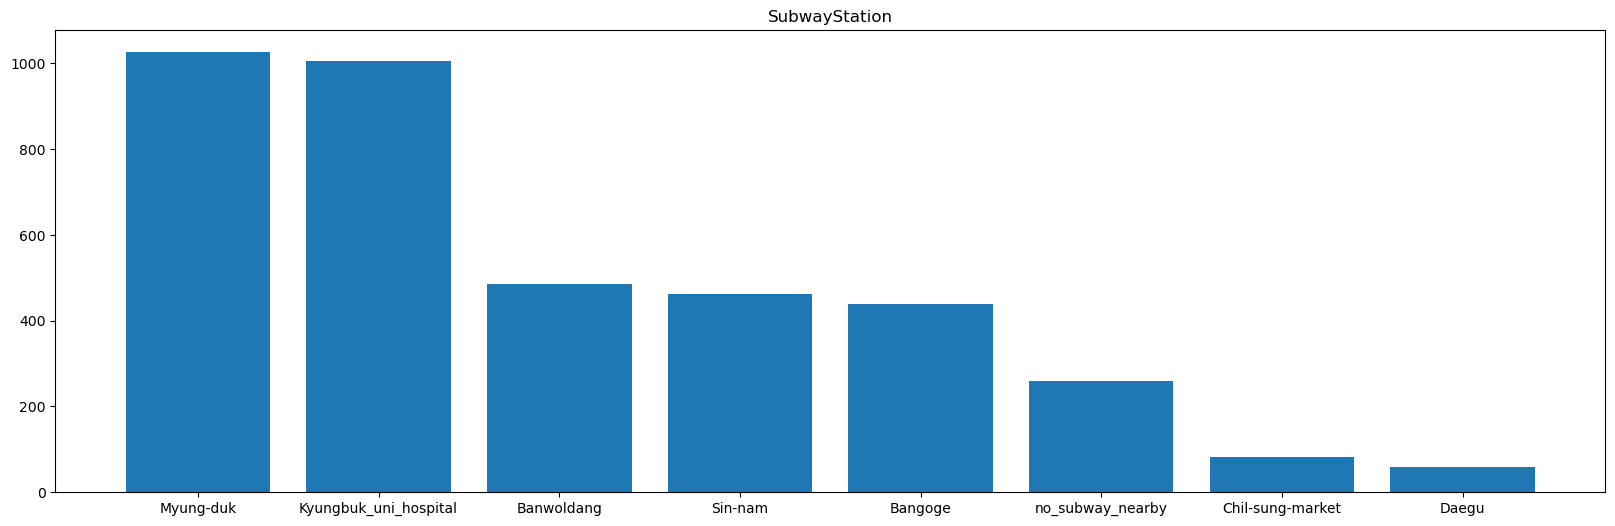

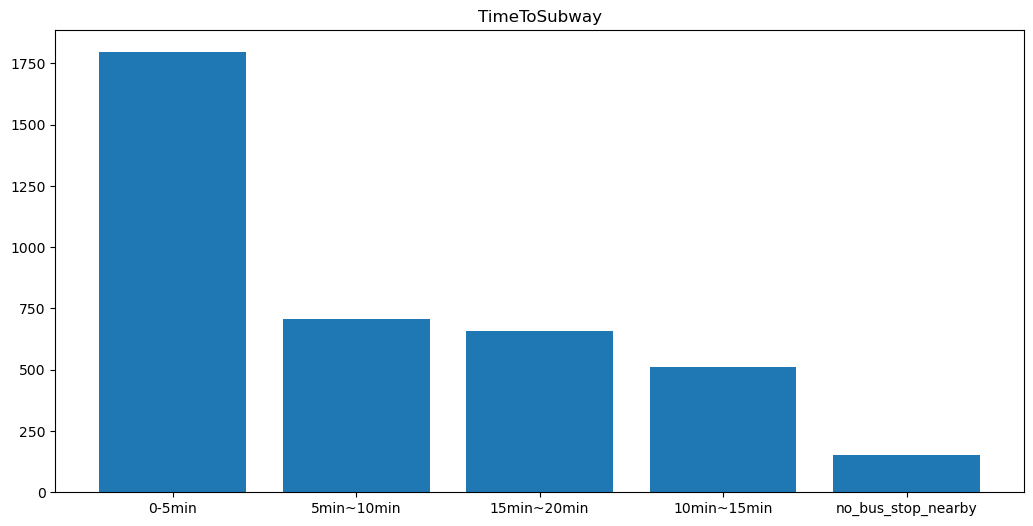

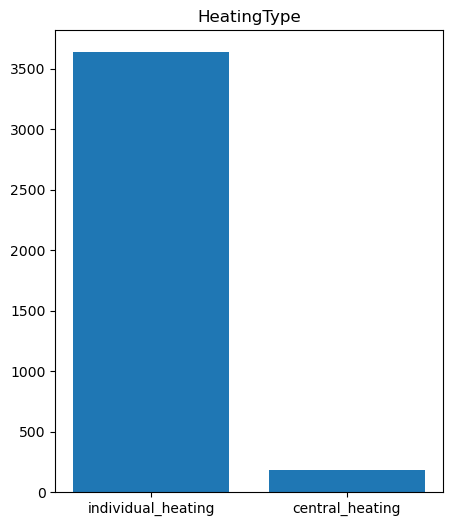

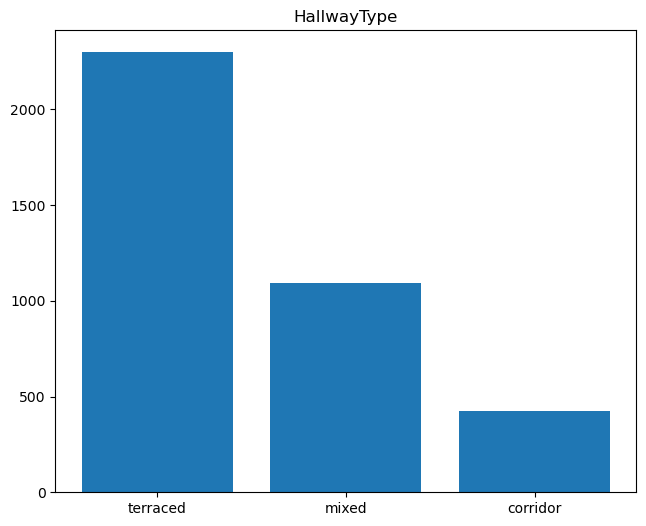

In [15]:
for col in categorical_columns:
    preprocessing.plot_bar(df[col].value_counts(), col, size=(2.5*len(df[col].value_counts()), 6))

## Analyzing the data imbalance

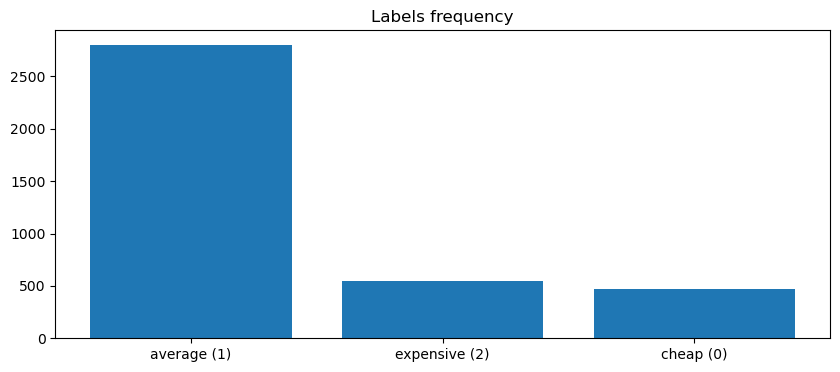

In [16]:
preprocessing.plot_bar(counts_by_label, "Labels frequency")

In [17]:
weights = preprocessing.calculate_class_weights(df["Label"])
weights

tensor([2.6899, 0.4542, 2.3432])

## Final preprocessing
Data is split into training and validation set in 4:1 ratio.

For preprocessing we:
- convert nominal features to one-hot vectors
- convert ordinal features to ordinal encoding, while keeping the correct order (0-5min: 0, 5-10min: 1 etc.)
- scale the numeric features using min-max scaler; we chose this normalization because none of the features have normal distribution
- **(only for training set)** oversample the minority classes to account for data imbalance; we've tested both undersampling and oversampling, and oversampling had better results

In [18]:
X = df.drop(columns=["Label"])
y = df["Label"]
train_x, val_x, train_y, val_y = train_test_split(X, y, test_size=0.2)
train_x, train_y = preprocessing.preprocess(
    train_x,
    numeric_columns,
    ordinal_columns,
    nominal_columns,
    y=train_y,
    oversample=False,
    undersample=False,
    random_state=42,
    echo_ordinal_counts=True,
)
val_x, val_y = preprocessing.preprocess(
    val_x,
    numeric_columns,
    ordinal_columns,
    nominal_columns,
    y=val_y,
    oversample=False,
    undersample=False,
    random_state=42,
)

TimeToBusStop value counts:
TimeToBusStop
0~5min         2316
5min~10min      708
10min~15min      29
Name: count, dtype: int64
ordinal__TimeToBusStop value counts:
ordinal__TimeToBusStop
0.0    2316
1.0     708
2.0      29
Name: count, dtype: int64
TimeToSubway value counts:
TimeToSubway
0-5min                1451
5min~10min             579
15min~20min            516
10min~15min            388
no_bus_stop_nearby     119
Name: count, dtype: int64
ordinal__TimeToSubway value counts:
ordinal__TimeToSubway
0.0    1451
1.0     579
3.0     516
2.0     388
4.0     119
Name: count, dtype: int64


In [19]:
weights = preprocessing.calculate_class_weights(train_y)
weights

tensor([2.7579, 0.4539, 2.3024])

# Model and training
We experiment with different models to choose the correct architecture. Since accuracy metric for imbalanced tasks may be misleading we also introduce precision, recall, f1 score and ROC curve. The best model is chosen based on f1 score. For fair comparison each architecture is trained with the same hyperparameters.
We test models with different layer sizes, and depth. We use batch normalization for each architecture, since it almost always improves performance. All of the models use ReLU activation function. Influence of dropout is also tested.

In [20]:
architectures = [
    [
        {"linear": (27, 64), "batch_norm": 64, "activation": True},
        {"linear": (64, 32), "batch_norm": 32, "activation": True},
        {"linear": (32, 3)}
    ],
    [
        {"linear": (27, 128), "batch_norm": 128, "activation": True},
        {"linear": (128, 64), "batch_norm": 64, "activation": True},
        {"linear": (64, 3)}
    ],
    [
        {"linear": (27, 128), "batch_norm": 128, "activation": True},
        {"linear": (128, 64), "batch_norm": 64, "activation": True},
        {"linear": (64, 32), "batch_norm": 32, "activation": True},
        {"linear": (32, 3)}
    ],
    [
        {"linear": (27, 64), "batch_norm": 64, "activation": True},
        {"dropout": 0.3, "linear": (64, 32), "batch_norm": 32, "activation": True},
        {"dropout": 0.3, "linear": (32, 3)}
    ],
    [
        {"linear": (27, 128), "batch_norm": 128, "activation": True},
        {"dropout": 0.3, "linear": (128, 64), "batch_norm": 64, "activation": True},
        {"dropout": 0.3, "linear": (64, 3)}
    ],
    [
        {"linear": (27, 128), "batch_norm": 128, "activation": True},
        {"dropout": 0.3, "linear": (128, 64), "batch_norm": 64, "activation": True},
        {"dropout": 0.3, "linear": (64, 32), "batch_norm": 32, "activation": True},
        {"dropout": 0.3, "linear": (32, 3)}
    ],
]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
training_setup = {"epochs": 60, "lr": 3e-4, "batch_size": 64, "class_weights": None}
losses, train_accuracy, train_precision, train_recall, train_f1, train_confusion_matrix, train_roc_curve, val_accuracy, val_precision, val_recall, val_f1, val_confusion_matrix, val_roc_curve = tune_architecture(train_x, train_y, val_x, val_y, architectures, training_setup, device)

Training model 0
Epoch: 0, loss: 0.8461247396965822
Epoch: 1, loss: 0.6324802165230116
Epoch: 2, loss: 0.5374714061617851
Epoch: 3, loss: 0.47773976624011993
Epoch: 4, loss: 0.44698607300718624
Epoch: 5, loss: 0.43580791850884754
Epoch: 6, loss: 0.4157199605057637
Epoch: 7, loss: 0.39929145636657876
Epoch: 8, loss: 0.3882299953450759
Epoch: 9, loss: 0.3850542278960347
Epoch: 10, loss: 0.3792038618897398
Epoch: 11, loss: 0.36846141517162323
Epoch: 12, loss: 0.363174787722528
Epoch: 13, loss: 0.3615163055558999
Epoch: 14, loss: 0.3588689807802439
Epoch: 15, loss: 0.3580688340589404
Epoch: 16, loss: 0.3525420883670449
Epoch: 17, loss: 0.3481456534937024
Epoch: 18, loss: 0.34127562927703065
Epoch: 19, loss: 0.335477976128459
Epoch: 20, loss: 0.3385649441430966
Epoch: 21, loss: 0.33112730116893846
Epoch: 22, loss: 0.33350686884174746
Epoch: 23, loss: 0.33058620026956004
Epoch: 24, loss: 0.32833057766159374
Epoch: 25, loss: 0.32711586604515713
Epoch: 26, loss: 0.3268244909122586
Epoch: 27, l

In [21]:
architecture_results = pd.DataFrame({"models": architectures, "train accuracy": train_accuracy, "train precision": train_precision, "train recall": train_recall, "train f1": train_f1, "val accuracy": val_accuracy, "val precision": val_precision, "val recall": val_recall, "val f1": val_f1})
architecture_results

,models,train accuracy,train precision,train recall,train f1,val accuracy,val precision,val recall,val f1
0,"[{'linear': (27, 64), 'batch_norm': 64, 'activ...",0.868326,0.868326,0.868326,0.868326,0.865183,0.865183,0.865183,0.865183
1,"[{'linear': (27, 128), 'batch_norm': 128, 'act...",0.870619,0.870619,0.870619,0.870619,0.865183,0.865183,0.865183,0.865183
2,"[{'linear': (27, 128), 'batch_norm': 128, 'act...",0.872257,0.872257,0.872257,0.872257,0.867801,0.867801,0.867801,0.867801
3,"[{'linear': (27, 64), 'batch_norm': 64, 'activ...",0.859482,0.859482,0.859482,0.859482,0.863874,0.863874,0.863874,0.863874
4,"[{'linear': (27, 128), 'batch_norm': 128, 'act...",0.855224,0.855224,0.855224,0.855224,0.861257,0.861257,0.861257,0.861257
5,"[{'linear': (27, 128), 'batch_norm': 128, 'act...",0.853259,0.853259,0.853259,0.853259,0.856021,0.856021,0.856021,0.856021


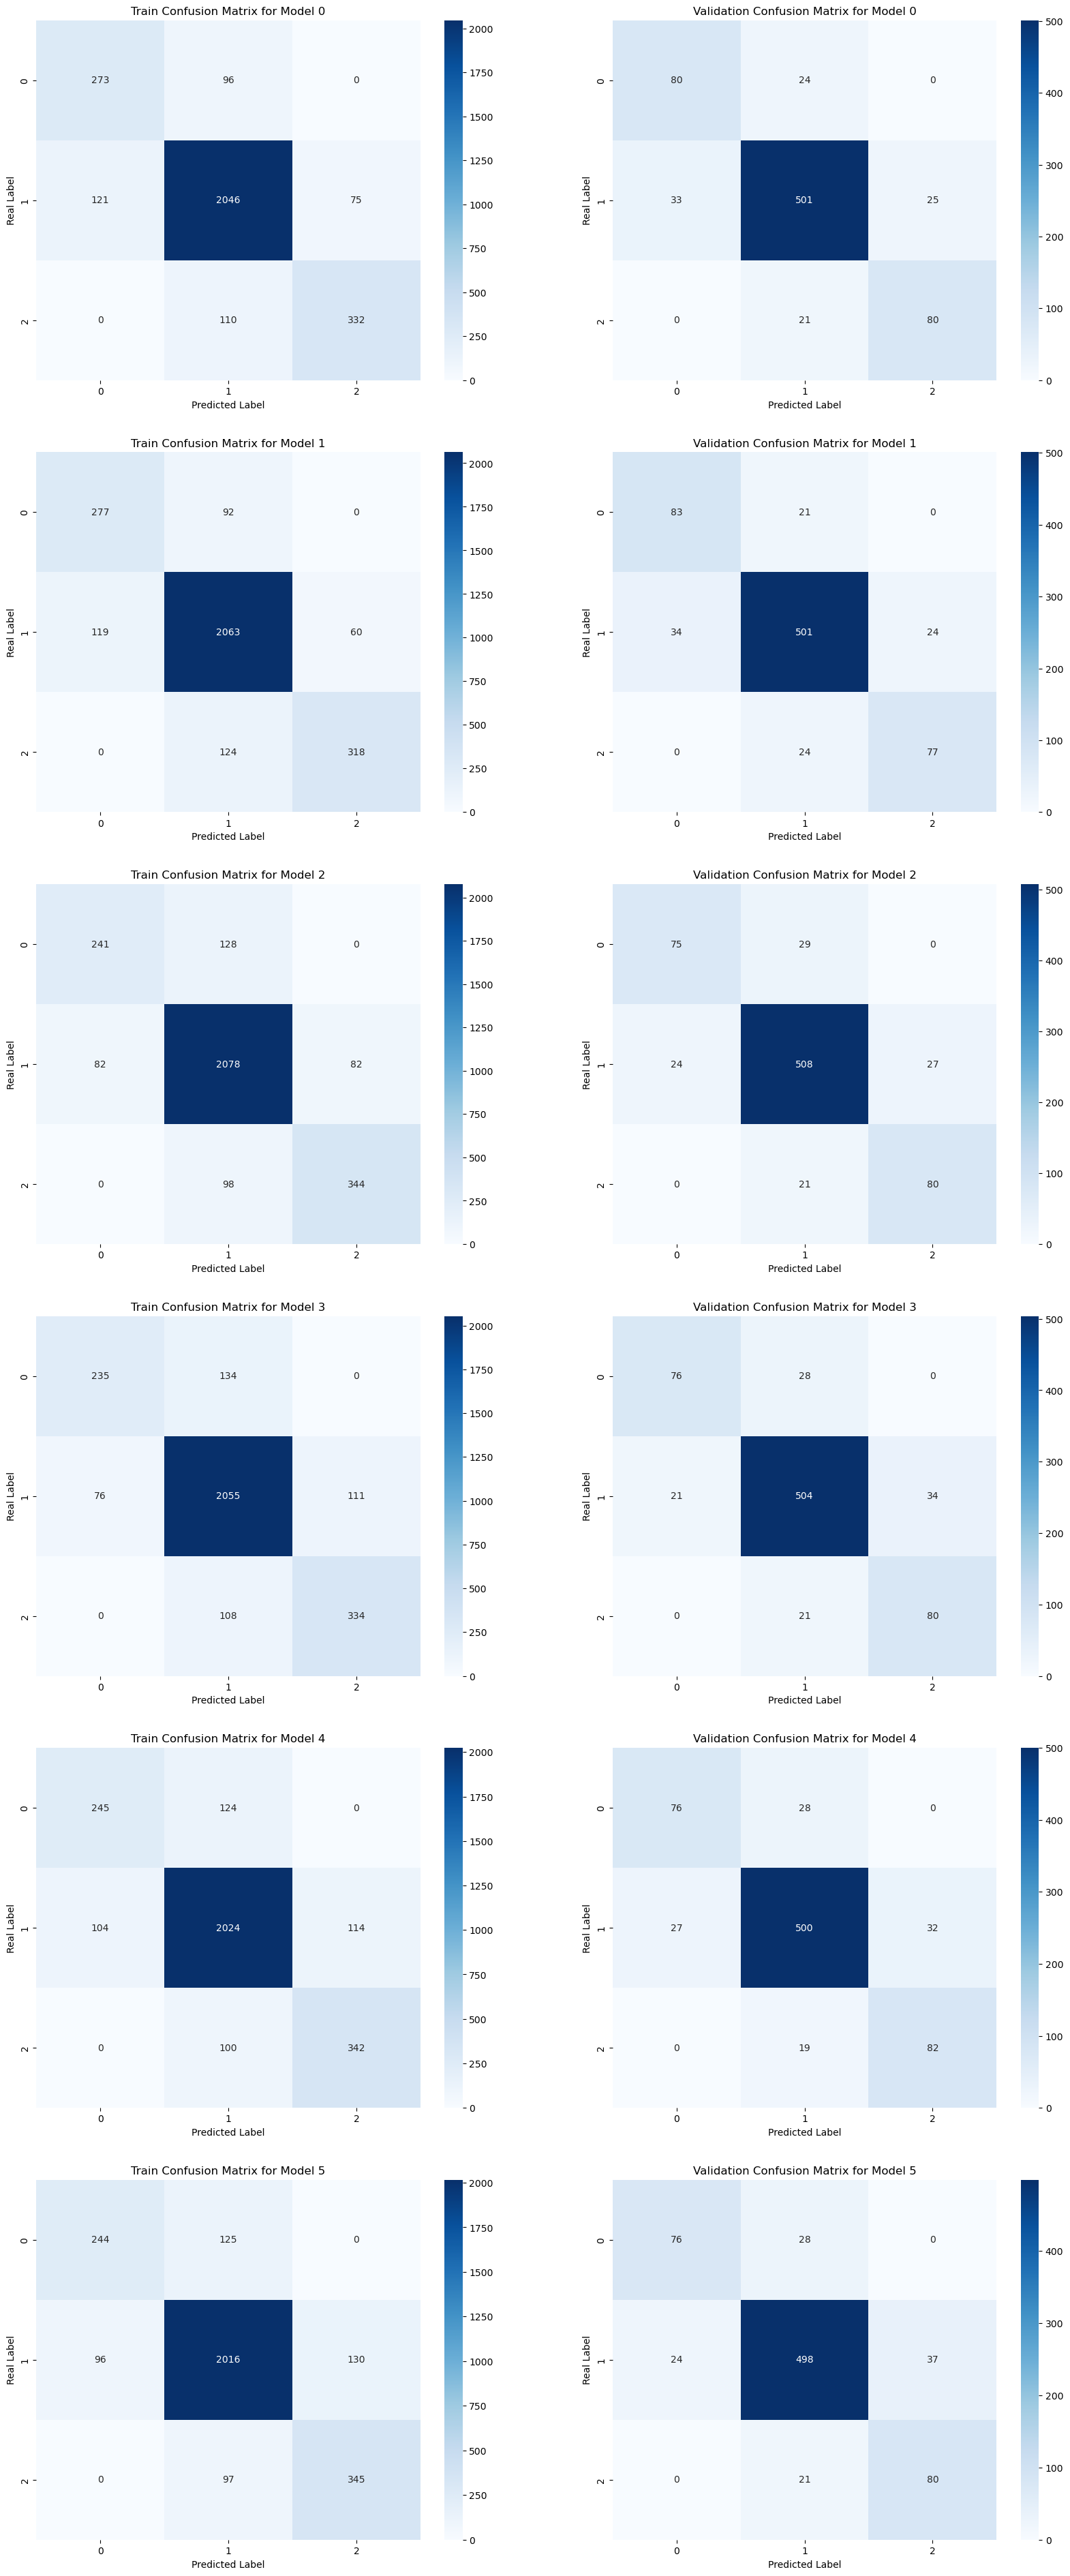

In [22]:
plot_confusion_matrices(train_confusion_matrix, val_confusion_matrix)

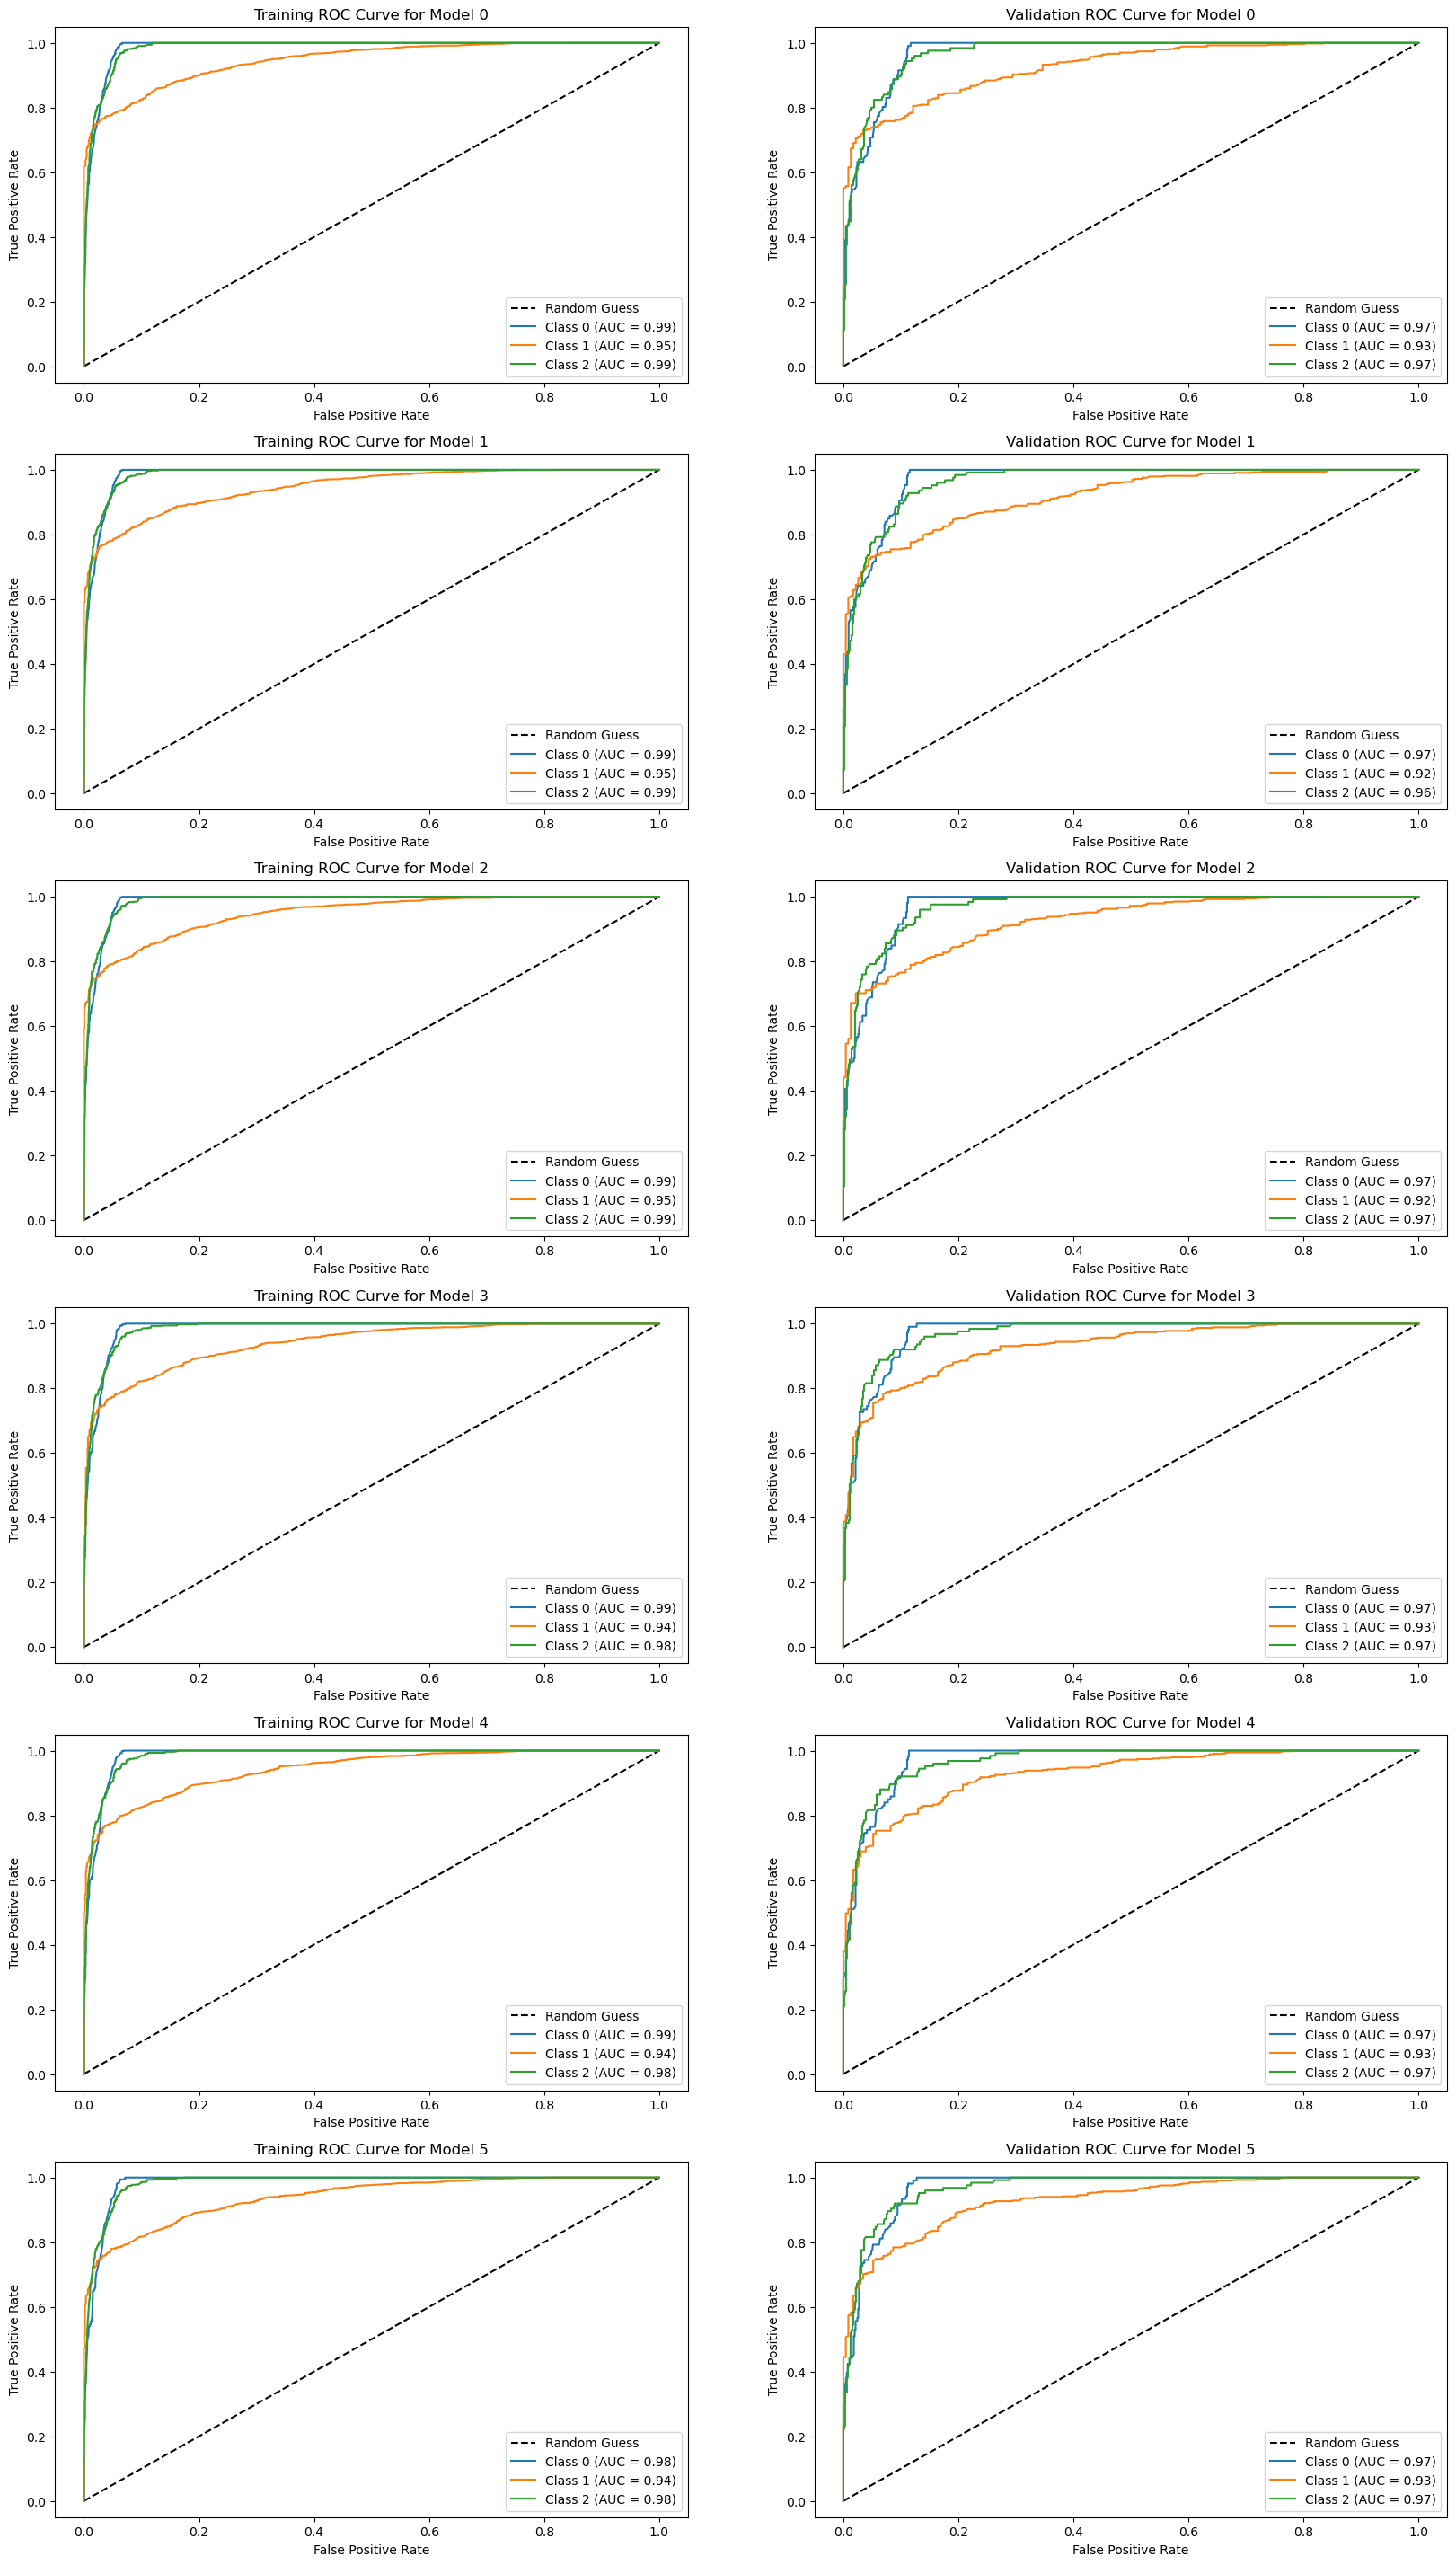

In [22]:
plot_roc_curves(train_roc_curve, val_roc_curve)

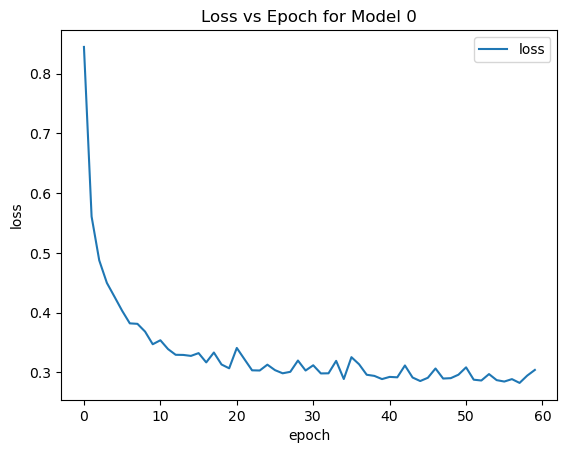

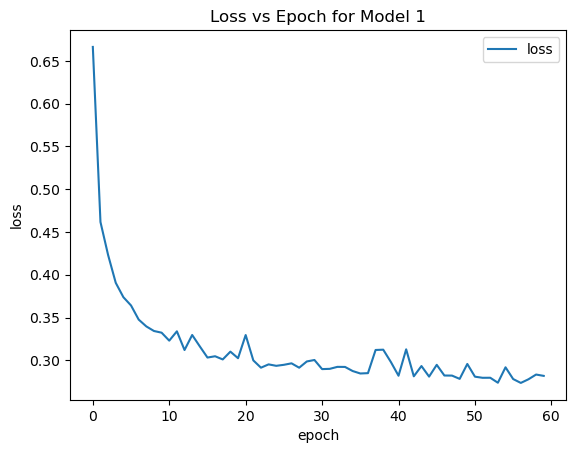

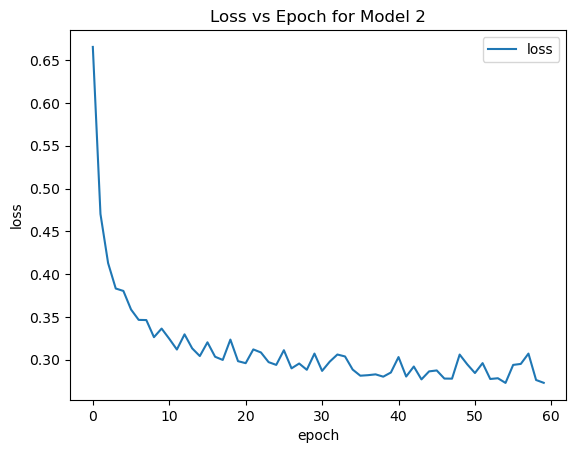

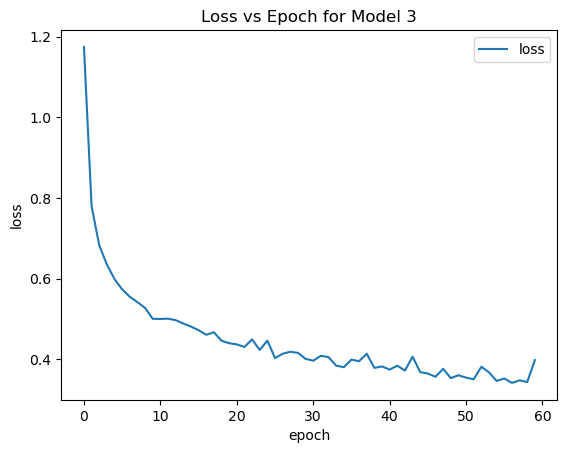

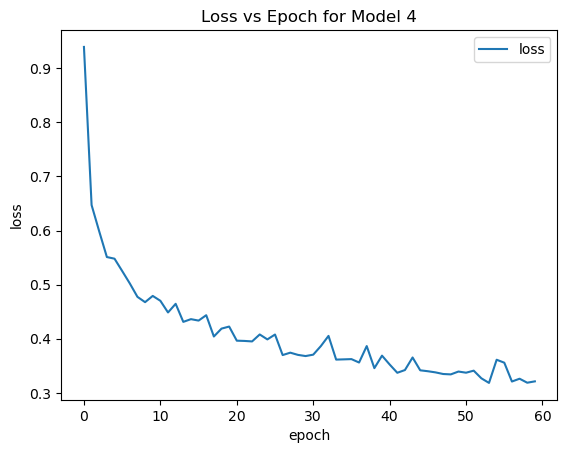

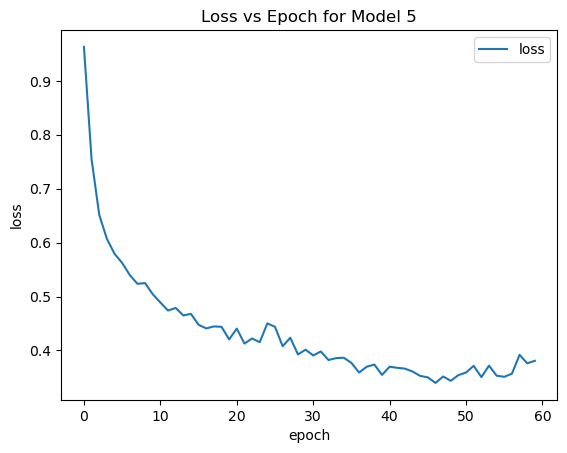

In [24]:
plot_losses(losses)

## Hyperparameter tuning
We then take the best performing architecture, train it with different hyperparameters and once again choose the best one based on f1 score.

In [ ]:
hyperparameters = [
    {"epochs": 60, "lr": 3e-2, "batch_size": 64, "class_weights": None},
    {"epochs": 60, "lr": 3e-2, "batch_size": 128, "class_weights": None},
    {"epochs": 60, "lr": 3e-3, "batch_size": 64, "class_weights": None},
    {"epochs": 60, "lr": 3e-3, "batch_size": 128, "class_weights": None},
    {"epochs": 60, "lr": 3e-4, "batch_size": 64, "class_weights": None},
    {"epochs": 60, "lr": 3e-4, "batch_size": 128, "class_weights": None},
    {"epochs": 60, "lr": 3e-5, "batch_size": 64, "class_weights": None},
    {"epochs": 60, "lr": 3e-5, "batch_size": 128, "class_weights": None},
    ]
final_model, losses, train_accuracy, train_precision, train_recall, train_f1, train_confusion_matrix, train_roc_curve, val_accuracy, val_precision, val_recall, val_f1, val_confusion_matrix, val_roc_curve = tune_hyperparameters(train_x, train_y, val_x, val_y, architectures[5], hyperparameters, device)

Training model 0
Epoch: 0, loss: 0.5178959366847884
Epoch: 1, loss: 0.4444472398960365
Epoch: 2, loss: 0.41319493668259316
Epoch: 3, loss: 0.43597907263715313
Epoch: 4, loss: 0.44493633817951633
Epoch: 5, loss: 0.3632090249151554
Epoch: 6, loss: 0.37615206809538715
Epoch: 7, loss: 0.3555450657347463
Epoch: 8, loss: 0.3412680599205899
Epoch: 9, loss: 0.4097012181608182
Epoch: 10, loss: 0.39929469337440887
Epoch: 11, loss: 0.34823540668442565
Epoch: 12, loss: 0.3559945679779323
Epoch: 13, loss: 0.39513115542677213
Epoch: 14, loss: 0.3483413239976145
Epoch: 15, loss: 0.35050833548577326
Epoch: 16, loss: 0.33510401746574436
Epoch: 17, loss: 0.33488921554021117
Epoch: 18, loss: 0.3542045783602966
Epoch: 19, loss: 0.343849352929952
Epoch: 20, loss: 0.34606692054361665
Epoch: 21, loss: 0.33545915585643843
Epoch: 22, loss: 0.37546169125246553
Epoch: 23, loss: 0.39739465390173895
Epoch: 24, loss: 0.3614848481034333
Epoch: 25, loss: 0.3836841139028657
Epoch: 26, loss: 0.4494690213282153
Epoch: 2

In [26]:
hyperparameters_results = pd.DataFrame({"models": [architectures[5]]*len(hyperparameters), "train accuracy": train_accuracy, "train precision": train_precision, "train recall": train_recall, "train f1": train_f1, "val accuracy": val_accuracy, "val precision": val_precision, "val recall": val_recall, "val f1": val_f1})
hyperparameters_results

,models,train accuracy,train precision,train recall,train f1,val accuracy,val precision,val recall,val f1
0,"[{'linear': (27, 128), 'batch_norm': 128, 'act...",0.884558,0.884558,0.884558,0.884558,0.893516,0.893516,0.893516,0.893516
1,"[{'linear': (27, 128), 'batch_norm': 128, 'act...",0.890955,0.890955,0.890955,0.890955,0.900059,0.900059,0.900059,0.900059
2,"[{'linear': (27, 128), 'batch_norm': 128, 'act...",0.893930,0.893930,0.893930,0.893930,0.898870,0.898870,0.898870,0.898870
3,"[{'linear': (27, 128), 'batch_norm': 128, 'act...",0.889616,0.889616,0.889616,0.889616,0.893516,0.893516,0.893516,0.893516
4,"[{'linear': (27, 128), 'batch_norm': 128, 'act...",0.886046,0.886046,0.886046,0.886046,0.886377,0.886377,0.886377,0.886377
5,"[{'linear': (27, 128), 'batch_norm': 128, 'act...",0.883666,0.883666,0.883666,0.883666,0.892326,0.892326,0.892326,0.892326
6,"[{'linear': (27, 128), 'batch_norm': 128, 'act...",0.780720,0.780720,0.780720,0.780720,0.801309,0.801309,0.801309,0.801309
7,"[{'linear': (27, 128), 'batch_norm': 128, 'act...",0.806010,0.806010,0.806010,0.806010,0.826294,0.826294,0.826294,0.826294


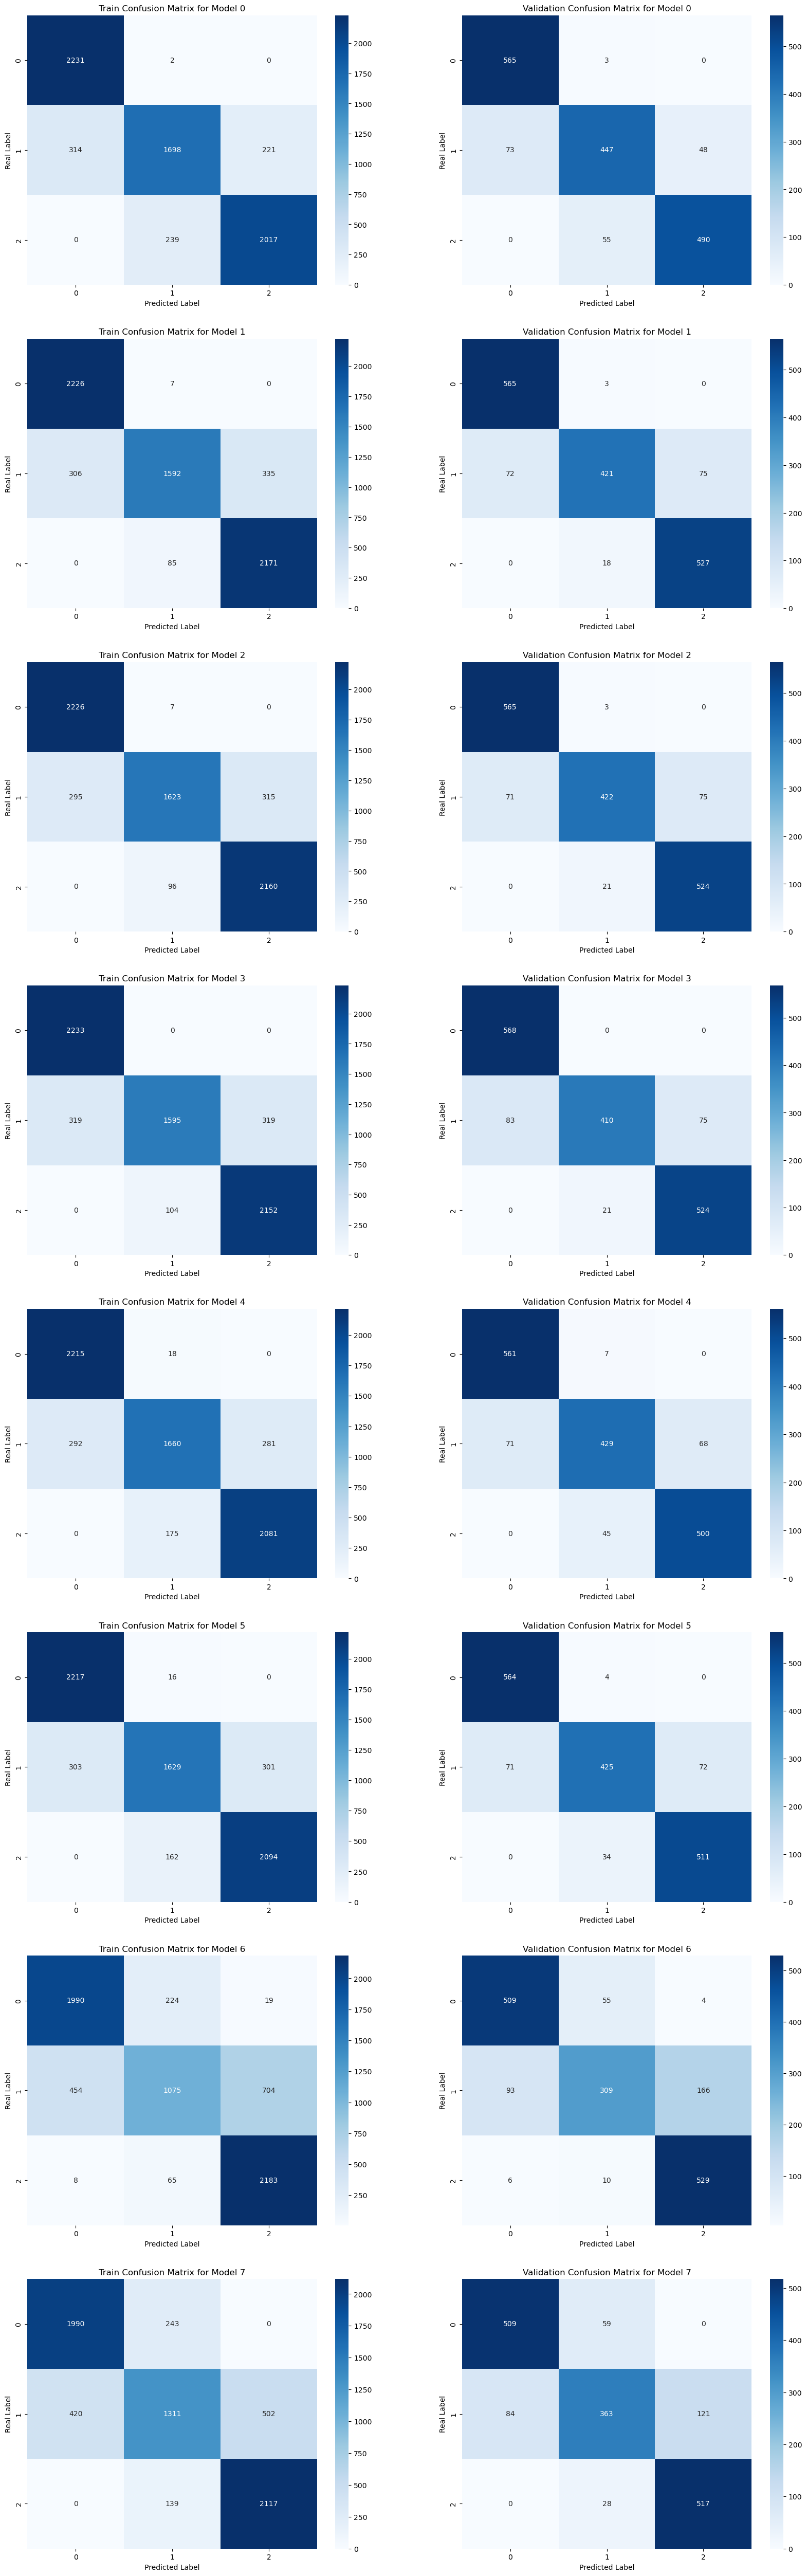

In [27]:
plot_confusion_matrices(train_confusion_matrix, val_confusion_matrix)

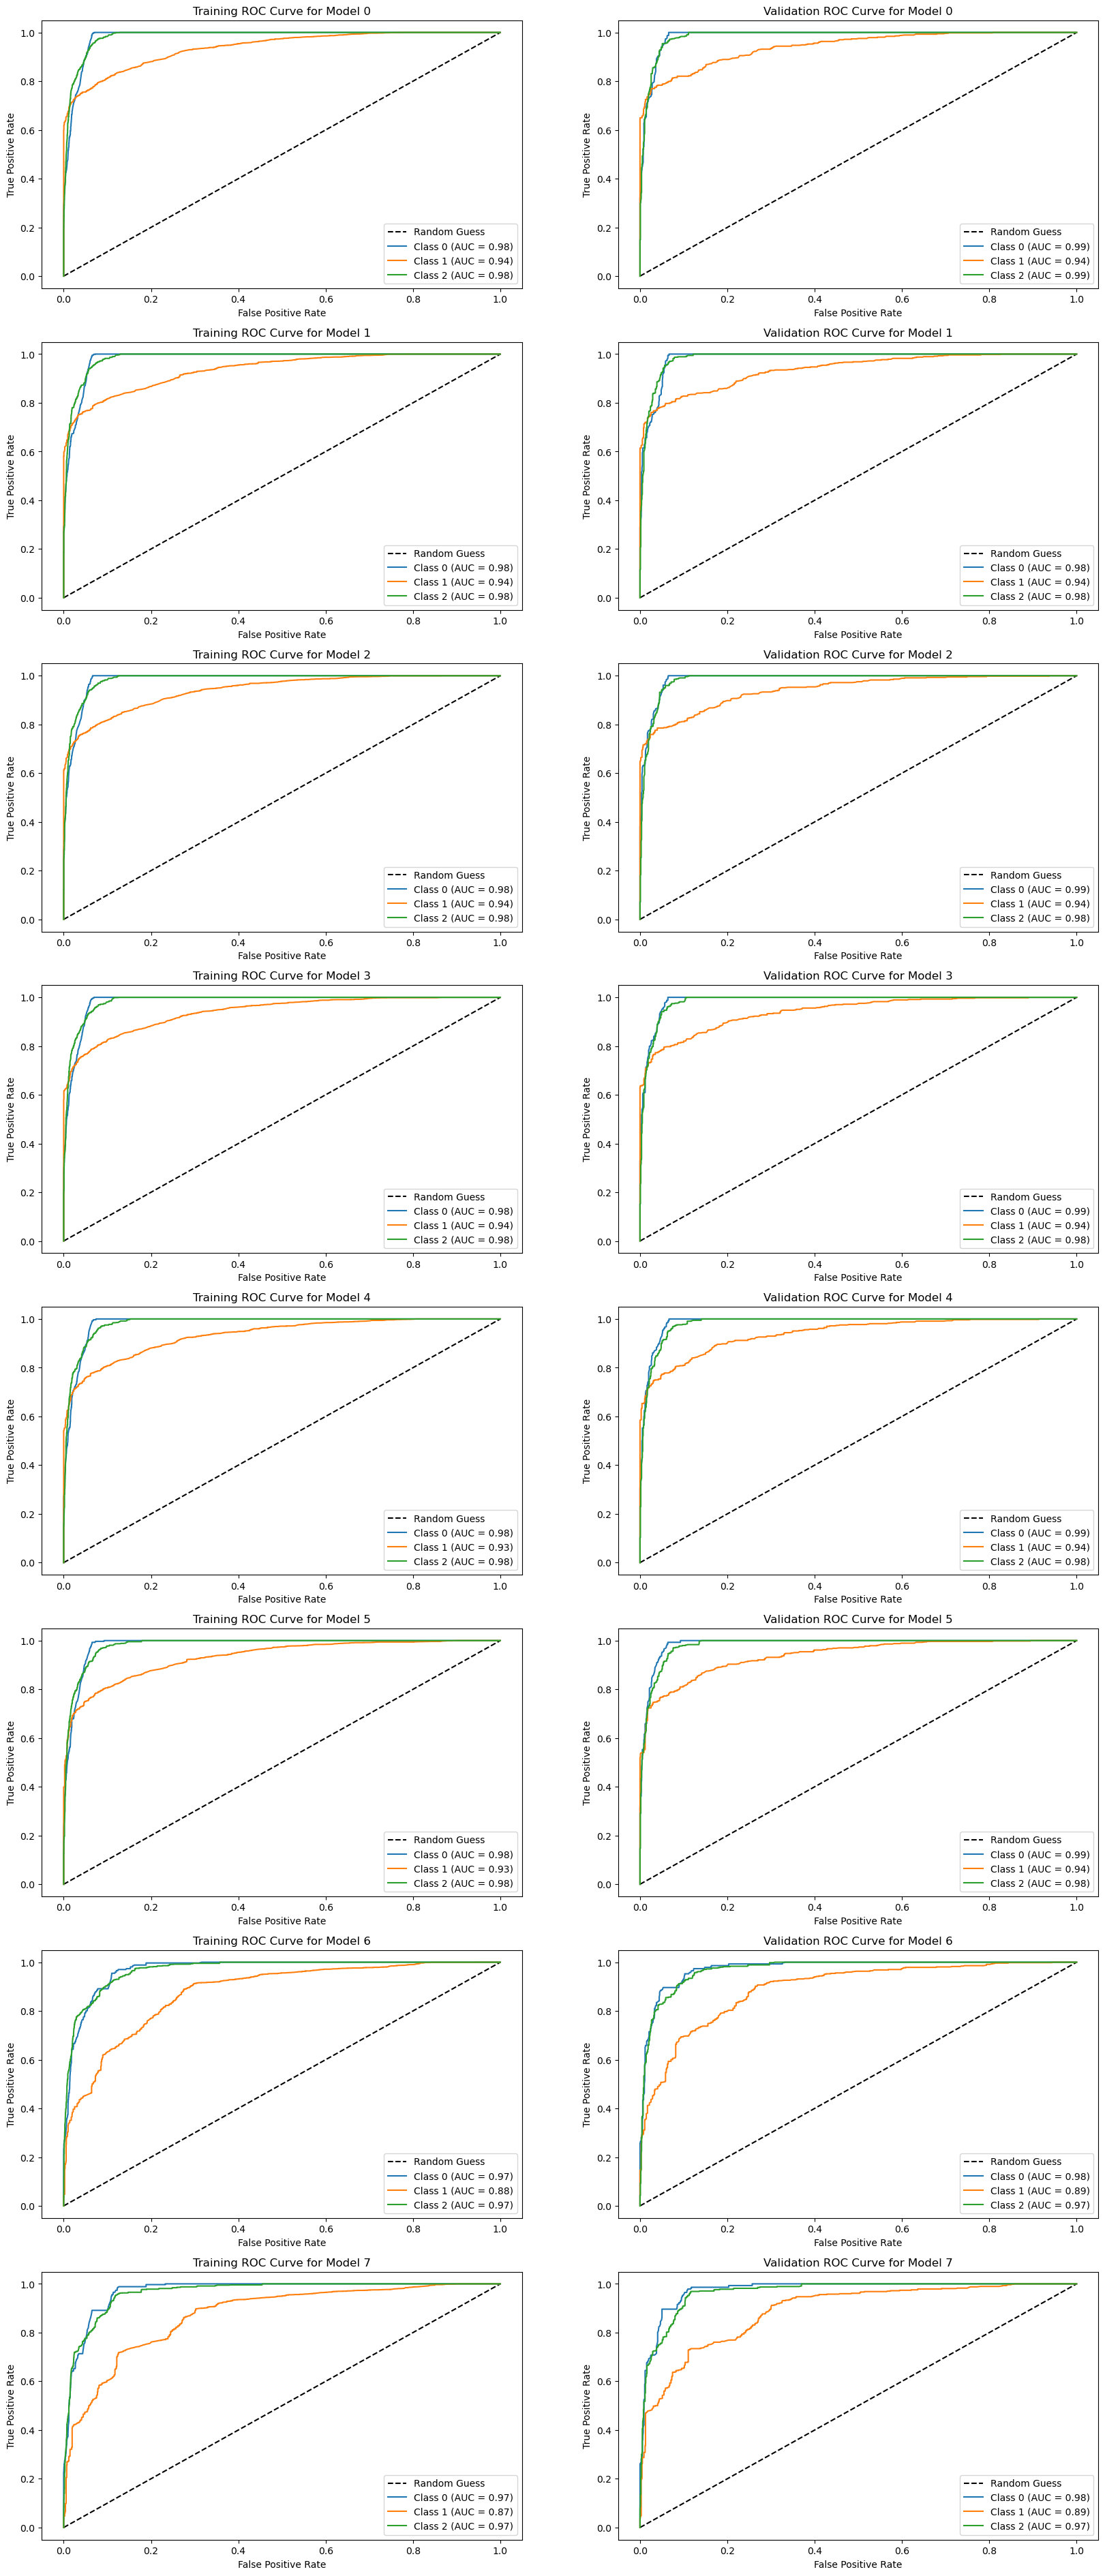

In [28]:
plot_roc_curves(train_roc_curve, val_roc_curve)

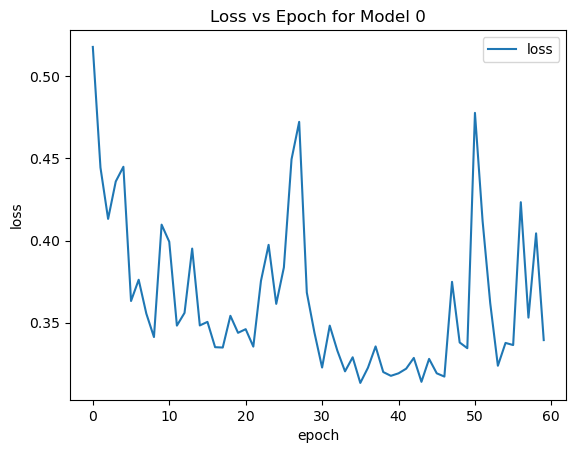

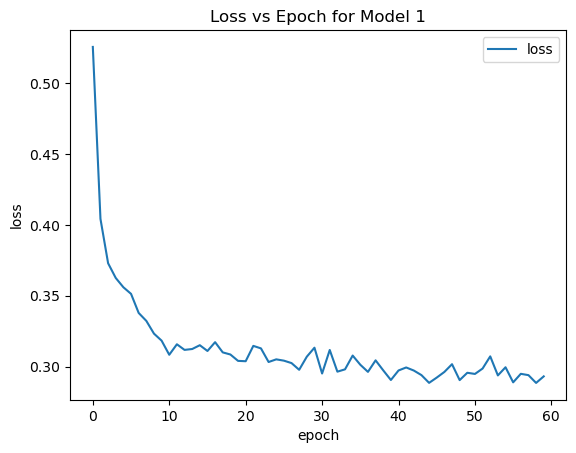

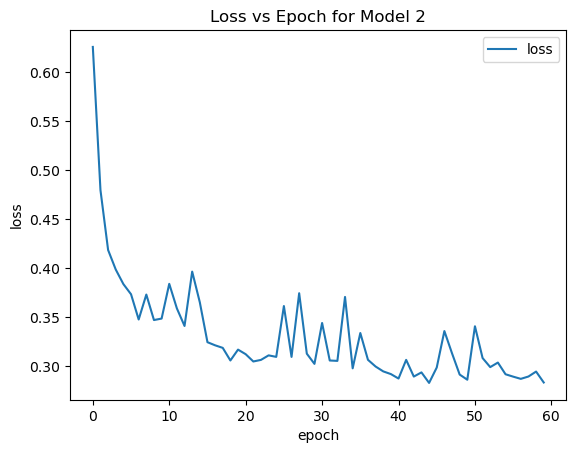

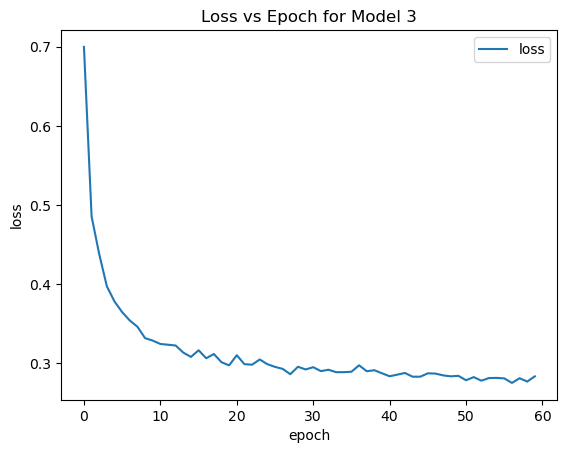

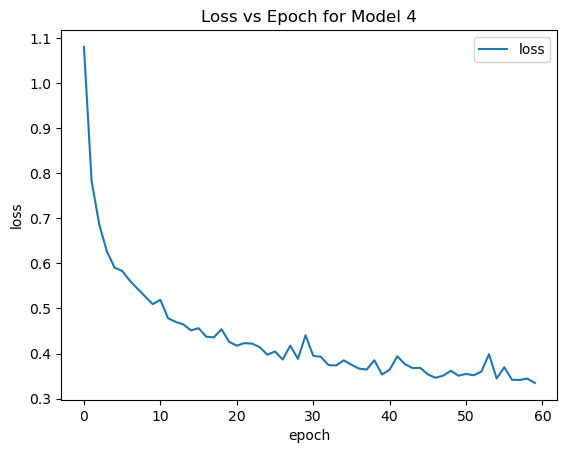

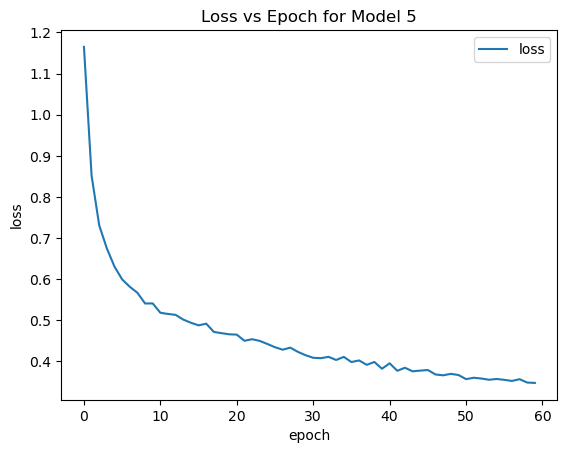

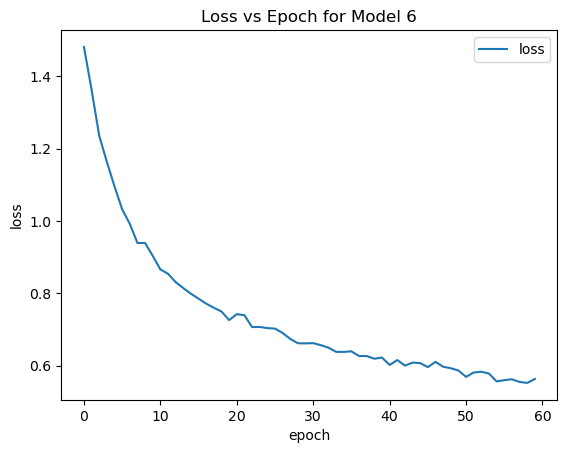

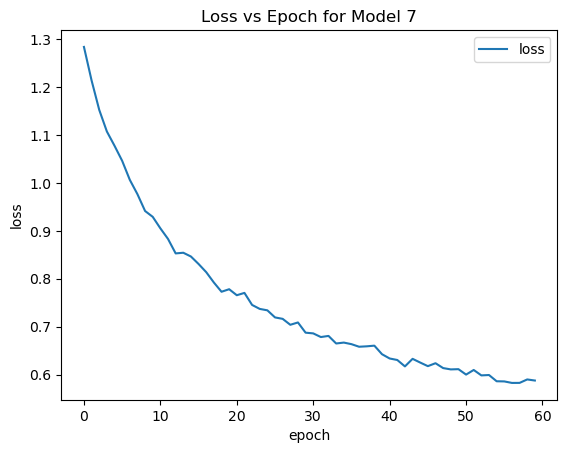

In [29]:
plot_losses(losses)

# Predict on test data

In [ ]:
df_test = pd.read_csv("test_data.csv")
test_x = preprocessing.preprocess(df_test, numeric_columns, ordinal_columns, nominal_columns, y=pd.Series(), oversample=False, undersample=False, random_state=42, echo_ordinal_counts=False)

In [32]:
test_preds = predict(final_model, test_x)
np.savetxt("preds.csv", test_preds, delimiter=",", fmt='%d')

# Conclusions


In [ ]:
df_del = pd.read_csv("DaeguApartments.csv")
df_del["Label"] = df_del["SalePrice"].apply(preprocessing.classify)
df = df.drop(columns=["SalePrice"])
y = df_del["Label"]
df_del = df_del.drop(columns=["Label"])
test_x = preprocessing.preprocess(df_test, numeric_columns, ordinal_columns, nominal_columns, y=pd.Series(), oversample=False, undersample=False, random_state=42, echo_ordinal_counts=False)

In [ ]:
test_preds = predict(final_model, test_x)


In [28]:
df_full = pd.read_csv('DaeguApartments.csv')     # has colA, colB, colC, label
df_subset = pd.read_csv('test_data.csv')
common_cols = df_subset.columns.tolist()
df_merged = pd.merge(
    df_subset,
    df_full,
    how='left',
    on=common_cols
)
df_merged

,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,...,N_FacilitiesNearBy(Hospital),N_FacilitiesNearBy(Dpartmentstore),N_FacilitiesNearBy(Mall),N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(Park),N_SchoolNearBy(Elementary),N_SchoolNearBy(Middle),N_SchoolNearBy(High),N_SchoolNearBy(University),FamilyFriendly
0,1993,914,10,mixed,individual_heating,management_in_trust,523.0,536.0,0~5min,15min~20min,...,2,0,1,5,0,4,3,5,5,0.0
1,1993,914,10,mixed,individual_heating,management_in_trust,523.0,536.0,0~5min,15min~20min,...,2,0,1,5,0,4,3,5,5,0.0
2,1993,914,10,mixed,individual_heating,management_in_trust,523.0,536.0,0~5min,15min~20min,...,2,0,1,5,0,4,3,5,5,0.0
3,1993,914,10,mixed,individual_heating,management_in_trust,523.0,536.0,0~5min,15min~20min,...,2,0,1,5,0,4,3,5,5,0.0
4,1993,914,10,mixed,individual_heating,management_in_trust,523.0,536.0,0~5min,15min~20min,...,2,0,1,5,0,4,3,5,5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12058,1993,914,9,mixed,individual_heating,management_in_trust,523.0,536.0,0~5min,15min~20min,...,2,0,1,5,0,4,3,5,5,0.0
12059,1993,914,9,mixed,individual_heating,management_in_trust,523.0,536.0,0~5min,15min~20min,...,2,0,1,5,0,4,3,5,5,0.0
12060,1993,914,9,mixed,individual_heating,management_in_trust,523.0,536.0,0~5min,15min~20min,...,2,0,1,5,0,4,3,5,5,0.0
12061,1993,914,9,mixed,individual_heating,management_in_trust,523.0,536.0,0~5min,15min~20min,...,2,0,1,5,0,4,3,5,5,0.0
